<a href="https://colab.research.google.com/github/Priyankavaishnav1006/Stock_Sales_ML_Model/blob/main/ML_Tested.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path= '/content/drive/MyDrive/ML Data 2.csv'  #load data
df = pd.read_csv(file_path)

#check 1st five and last five rows
print(df)

#check columns and data type
print(df.info())

          Rows No  Location ID    DealDate Currency Type  Type  Amount  \
0        28937647          140  04/01/2022      JMD    N     S   77000   
1        28937648          140  04/01/2022      XCD    N     S    1000   
2        28937649          140  04/01/2022      KRW    N     S  910000   
3        28937650          140  04/01/2022      EUR    N     S     705   
4        28937651          140  04/01/2022      TRY    N     S    3215   
...           ...          ...         ...      ...  ...   ...     ...   
8234155  46696722           38  30/04/2025      EUR    N     S     335   
8234156  46696723           38  30/04/2025      EUR    N     B     200   
8234157  46696724           38  30/04/2025      EUR    N     S     100   
8234158  46696725           38  30/04/2025      JPY    N     S   27000   
8234159  46696726          272  29/04/2025      EUR    N     S     340   

          Value  OriginationID  OrderTypeID  
0        401.68              2            2  
1        293.17    

In [ ]:
import warnings
warnings.filterwarnings("ignore")   # Ignore warnings

# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import holidays
from xgboost import XGBRegressor
df['Date']=pd.to_datetime(df['Date'], dayfirst=True)
df.rename(columns={'DealDate':'Date','Location ID':'Branch','Value':'Sales', 'OrderTypeID':'Channel'},inplace=True)
df=df[df['OriginationID']!=2] # Remove home delivery
df=df[['Date','Branch','Currency','Sales','Channel']].dropna() # Remove null values

In [12]:
#feature engineering

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek
uk_holidays = holidays.UnitedKingdom()
df['Is_Holiday'] = df['Date'].isin(uk_holidays).astype(int)
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

In [15]:
#top 10 branches and top 5 currency

top_branches = df.groupby('Branch')['Sales'].sum().nlargest(10).index.tolist()
df = df[df['Branch'].isin(top_branches)]
top_cur = (df.groupby(['Branch', 'Currency'])['Sales'].sum().reset_index()
             .groupby('Branch').apply(lambda x: x.nlargest(5, 'Sales'))['Currency'].reset_index())
df = pd.merge(df, top_cur, on=['Branch', 'Currency'], how='inner')

In [16]:
prophet_out = []
for (branch, currency), group in df.groupby(['Branch', 'Currency']):
    ts = group.groupby(pd.Grouper(key='Date', freq='M'))['Sales'].sum().reset_index()
    ts.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
    if len(ts) < 12:
        continue
    model = Prophet()
    model.add_country_holidays(country_name='UK')
    model.fit(ts)
    future = model.make_future_dataframe(periods=3, freq='M')
    forecast = model.predict(future)
    forecast['Branch'], forecast['Currency'] = branch, currency
    forecast.rename(columns={'yhat': 'Predicted_Sales'}, inplace=True)
    prophet_out.append(forecast[['ds', 'Predicted_Sales', 'Branch', 'Currency']])
df_prophet = pd.concat(prophet_out)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpohns_n2w/bh8c5aoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpohns_n2w/mv9bs5g7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65233', 'data', 'file=/tmp/tmpohns_n2w/bh8c5aoh.json', 'init=/tmp/tmpohns_n2w/mv9bs5g7.json', 'output', 'file=/tmp/tmpohns_n2w/prophet_modelngug81b0/prophet_model-20250620093045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

In [17]:
#XGBOOST WITH LAG FEATURES
monthly = df.groupby(['Branch', 'Currency', pd.Grouper(key='Date', freq='M')])['Sales'].sum().reset_index()
monthly = monthly.sort_values(['Branch', 'Currency', 'Date'])
monthly['Lag_1'] = monthly.groupby(['Branch', 'Currency'])['Sales'].shift(1)
monthly['Lag_2'] = monthly.groupby(['Branch', 'Currency'])['Sales'].shift(2)
monthly['Month'] = monthly['Date'].dt.month
monthly['Year'] = monthly['Date'].dt.year
monthly['DayOfWeek'] = monthly['Date'].dt.dayofweek
monthly.dropna(inplace=True)
xgb_data = pd.get_dummies(monthly, columns=['Branch', 'Currency'], drop_first=True)
X = xgb_data.drop(columns=['Date', 'Sales'])
y = xgb_data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("📊 XGBoost RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))
print("📊 XGBoost MAE:", round(mean_absolute_error(y_test, y_pred), 2))

📊 XGBoost RMSE: 82929.15
📊 XGBoost MAE: 25819.01


In [18]:
 #MERGE ACTUALS WITH PROPHET PREDICTIONS
actuals = df.groupby(['Branch', 'Currency', pd.Grouper(key='Date', freq='M')])['Sales'].sum().reset_index()
actuals.rename(columns={'Date': 'ds', 'Sales': 'Actual'}, inplace=True)
merged = pd.merge(df_prophet, actuals, on=['ds', 'Branch', 'Currency'], how='left')
merged['Error'] = merged['Actual'] - merged['Predicted_Sales']
merged['% Variance'] = (merged['Error'] / merged['Actual']) * 100

In [20]:
#PRINT FORECAST SUMMARY
latest = merged['ds'].max()
summary = merged[merged['ds'] == latest][['Branch', 'Currency', 'ds', 'Actual', 'Predicted_Sales', 'Error', '% Variance']]
print("\n📋 Forecast Summary for", latest.strftime('%B %Y'))
print(summary.sort_values('Branch').to_string(index=False, float_format='{:,.2f}'.format))


📋 Forecast Summary for July 2025
 Branch Currency         ds  Actual  Predicted_Sales  Error  % Variance
     28      AED 2025-07-31     NaN         6,953.52    NaN         NaN
     28      EUR 2025-07-31     NaN       435,014.92    NaN         NaN
     28      THB 2025-07-31     NaN         7,988.21    NaN         NaN
     28      TRY 2025-07-31     NaN        16,707.73    NaN         NaN
     28      USD 2025-07-31     NaN       219,711.29    NaN         NaN
     56      AED 2025-07-31     NaN         5,546.41    NaN         NaN
     56      CAD 2025-07-31     NaN         9,022.18    NaN         NaN
     56      EUR 2025-07-31     NaN       316,429.58    NaN         NaN
     56      TRY 2025-07-31     NaN        15,013.06    NaN         NaN
     56      USD 2025-07-31     NaN       190,649.77    NaN         NaN
     65      AED 2025-07-31     NaN         4,017.12    NaN         NaN
     65      EUR 2025-07-31     NaN       801,663.17    NaN         NaN
     65      PLN 2025-07-31   

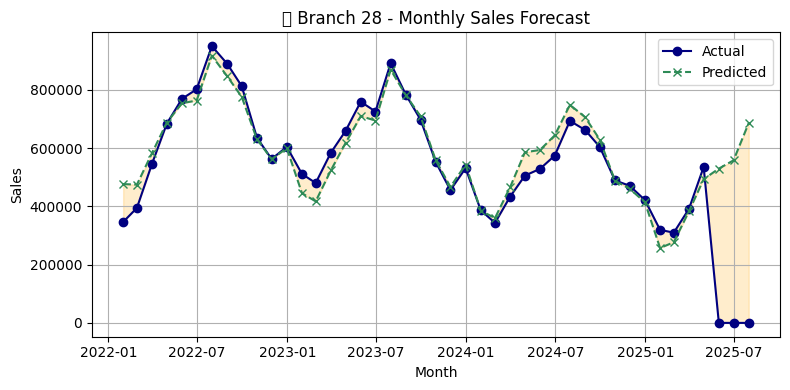

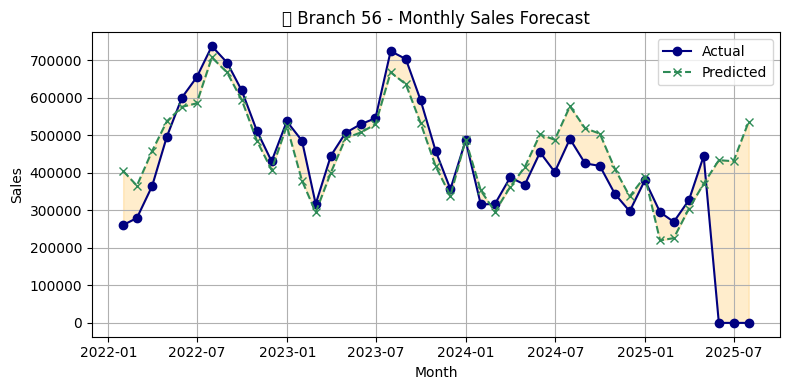

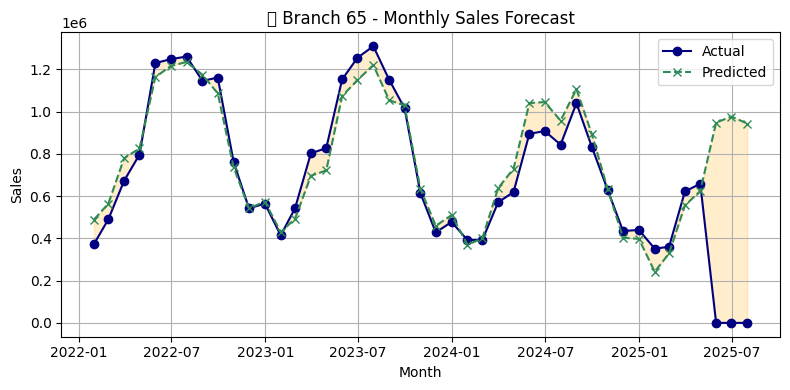

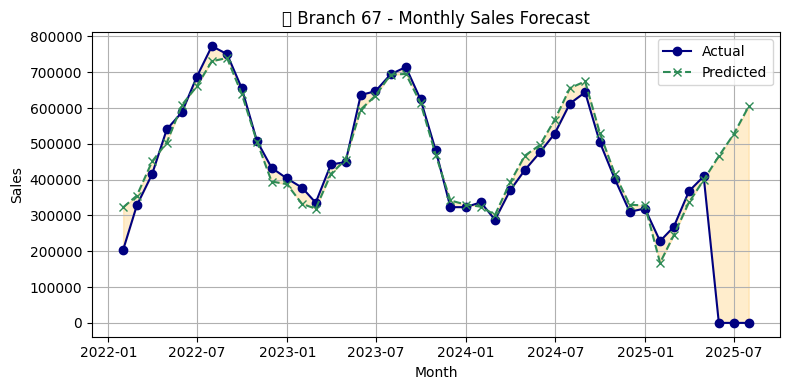

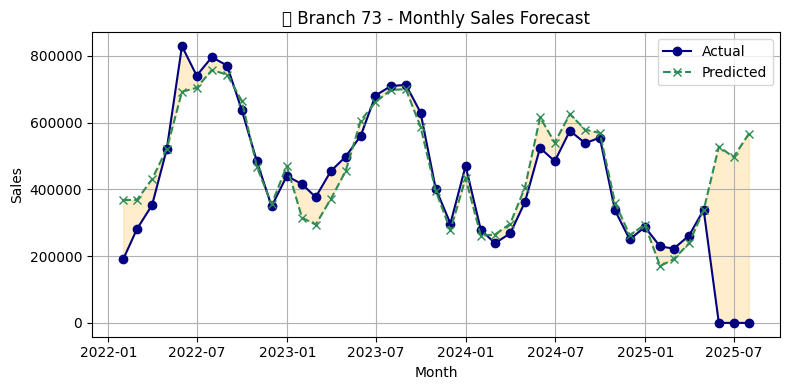

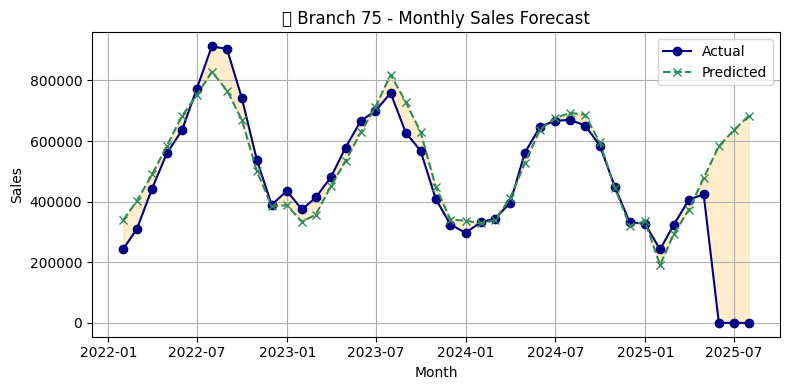

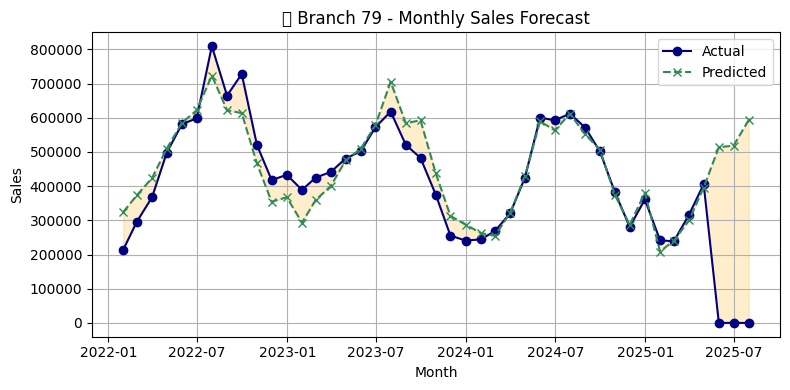

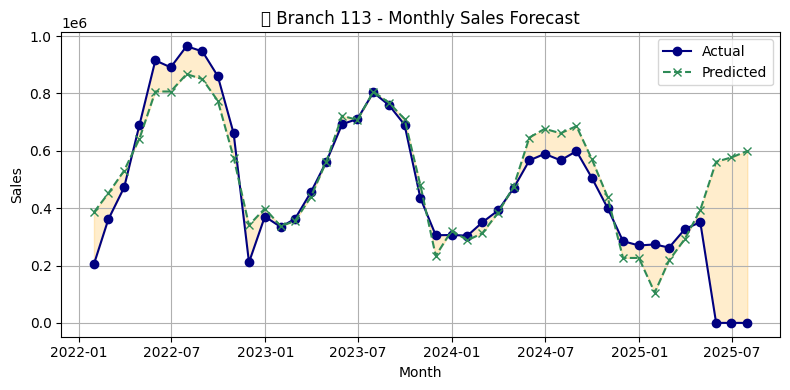

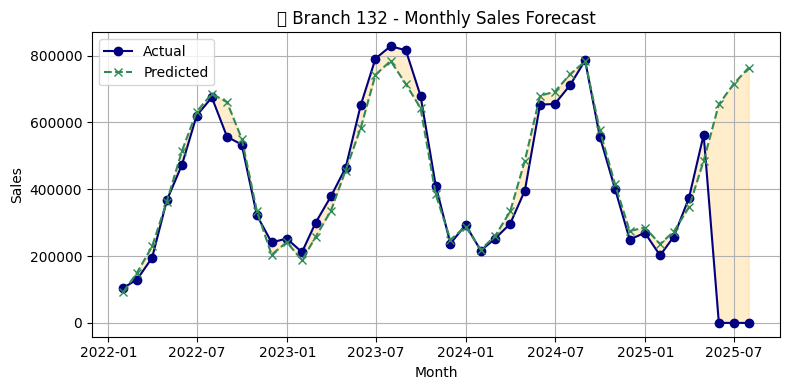

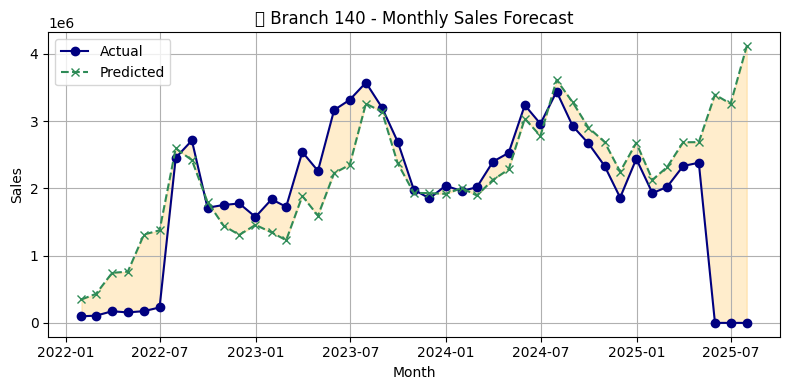

In [21]:
#PLOT FORECASTS PER BRANCH
for branch in merged['Branch'].unique():
    chart = merged[merged['Branch'] == branch].groupby('ds')[['Actual', 'Predicted_Sales']].sum().reset_index()
    plt.figure(figsize=(8, 4))
    plt.plot(chart['ds'], chart['Actual'], marker='o', label='Actual', color='navy')
    plt.plot(chart['ds'], chart['Predicted_Sales'], linestyle='--', marker='x', label='Predicted', color='seagreen')
    plt.fill_between(chart['ds'], chart['Actual'], chart['Predicted_Sales'], alpha=0.2, color='orange')
    plt.title(f"📍 Branch {branch} - Monthly Sales Forecast")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()